In [1]:
%matplotlib inline
from collections import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model

In [2]:
plt.rcParams["figure.figsize"] = (12, 6) # (w, h)
df = pd.read_csv("FD_csv_EEC18.csv", sep=';')

In [3]:
df.head()

,ANNEE,TRIM,CATAU2010R,METRODOM,TYPMEN7,AGE3,AGE5,COURED,ENFRED,NFRRED,...,DIP11,CSTOTPRM,IDENTM,EXTRIAN,EMPNBH,HREC,HHCE,HPLUSA,JOURTR,NBTOTE
0,2018,1,1,1,1,50,60,2,2,1.0,...,70.0,86.0,1,91.456642,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,2,1,1,1,50,60,2,2,1.0,...,70.0,86.0,2,87.755703,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,1,1,1,50,60,2,2,1.0,...,70.0,86.0,3,89.006746,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,4,1,1,1,50,60,2,2,1.0,...,70.0,86.0,4,89.551839,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,1,3,1,3,30,30,1,2,1.0,...,50.0,62.0,5,84.182896,45.0,NaN,36.0,NaN,4.0,NaN


In [4]:
def plot_summaries_amount_of_work_1(worked, worked_desired):
    # Trying a linear regression but it is actually not very well adapted (as you can see from the plot)
    reg = linear_model.LinearRegression()
    reg.fit(X=worked.values.reshape(-1, 1), y=worked_desired.values)
    slope = reg.coef_[0]
    intercept = reg.intercept_
    print("Regression:", slope, intercept)
    lo, hi = worked.min(), worked.max()
    lo_val = lo * slope + intercept
    hi_val = hi * slope + intercept
    
    # Plotting the information
    fig, plots = plt.subplots(nrows=1, ncols=3)
    plots[0].hexbin(x=worked, y=worked_desired, gridsize=(20, 20), cmap='Blues')
    plots[0].plot([lo, hi], [lo_val, hi_val], linestyle='-', color='orange')
    plots[0].plot([lo, hi], [lo, hi], linestyle='-', color='darkgreen')
    plots[1].hist(worked, bins=100)
    plots[2].scatter(x=worked, y=worked_desired, alpha=0.01, marker='.')
    plots[2].plot([lo, hi], [lo_val, hi_val], linestyle='-', color='orange')
    plots[2].plot([lo, hi], [lo, hi], linestyle='-', color='darkgreen')
    plt.tight_layout()
    plt.show()

def sub_sample(serie, count: int):
    """
    Select a sub-part of the series (random sample of 'count' entries)
    """
    if len(serie) < count:
        return serie
    return serie.sample(n=count)
    
def amount_of_work_desired_1(df):
    active = df.loc[df["ACTEU"] == 1]
    reduced = active[["HHCE",       # Worked hours
                      "HPLUSA",     # Desired worked hours
                      "SEXE",       # 1 for male, 2 for females
                      "COURED",     # 1 for couple, 2 if not in couple
                      "ENFRED"      # 1 if children, 2 if no children
                      ]].dropna()
    reduced = reduced.loc[(reduced["HPLUSA"] != 0) & (reduced["HHCE"] != 0)]

    # First thing to notice, the sampling processes is biased:
    # Interestingly, those who answer the question "how much to increase" have lower work amount
    worked = reduced["HHCE"]
    worked_desired = reduced["HPLUSA"]
    ratio = worked_desired / worked
    print(df['HHCE'].mean())
    print(worked.mean())
    print(worked_desired.mean())
    print(ratio.mean())

    # The scatter plot will leave you with the false impression that everyone is correctly represented
    # The Hexbin will show that there are parts that are really dense for people working 40hours
    plot_summaries_amount_of_work_1(worked, worked_desired)

    # So the idea is to re-sample to have equal number of participants in all categories?
    reduced = reduced.groupby('HHCE').apply(lambda x: sub_sample(x, 500))
    worked = reduced["HHCE"]
    worked_desired = reduced["HPLUSA"]
    plot_summaries_amount_of_work_1(worked, worked_desired)

36.74600672768359
32.435813016206396
37.90642295575171
1.4525011934846215
Regression: 0.4503966945940438 23.297439986781885


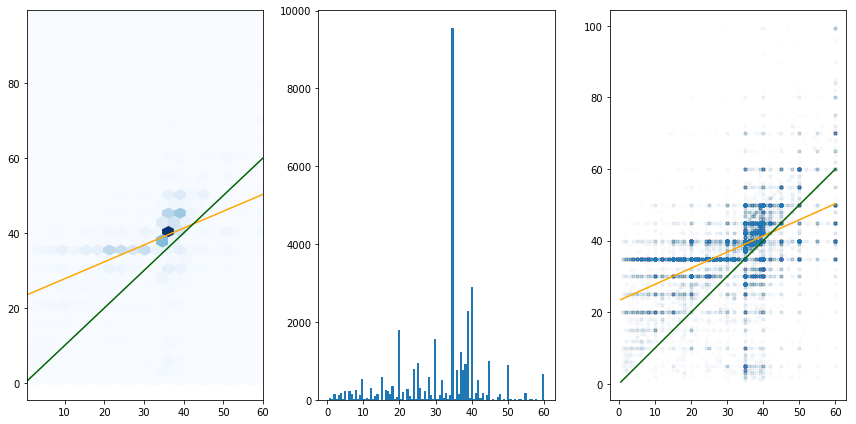

Regression: 0.4491749197884761 23.299838682221917


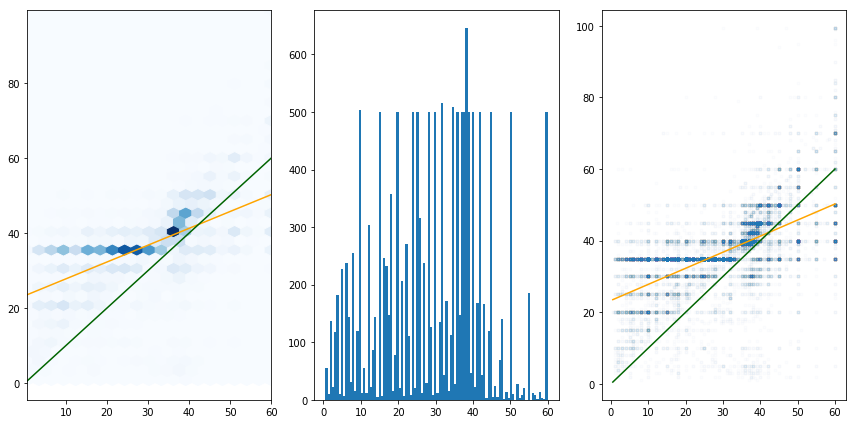

In [5]:
amount_of_work_desired_1(df)

In [51]:
def convert_status(status_id):
    if status_id == 1:
        return "Seul"
    elif status_id == 2:
        return "Famile monoparentale"
    elif status_id == 3:
        return "Couple sans enfants"
    elif status_id == 4:
        return "Couple avec enfants"
    elif status_id == 5:
        return "Collocation famille"
    elif status_id == 6:
        return "Collocation autre"
    else:
        return "Other"
    
def convert_inactivity(duration_id):
    types = {
        1:0,
        2:1,
        3:3,
        4:6,
        5:12,
        6:18,
        7:24,
        8:36
    }
    return types.get(duration_id, 0)

def x_and_y_of_hist(hist):
    return zip(*sorted(hist.items(), key=lambda p: p[0]))

def investigate_unemployed(df):
    df["Menage"] = df["TYPMEN7"].apply(convert_status)
    df["ChomageDuration"] = df["ANCCHOM"].apply(convert_inactivity)
    
    employed = df.loc[df["ACTEU"] == 1]
    unemployed = df.loc[df["ACTEU"] == 2]
    
    hist_duration = Counter(unemployed["ChomageDuration"])
    chom_duration, chom_count = x_and_y_of_hist(hist_duration)
    
    print("Unemployement ratio:", 100 * len(unemployed) / (len(employed) + len(unemployed)), "%")

    fig, plots = plt.subplots(nrows=1, ncols=2)

    # Plotting the information about the kind of menage
    plots[0].hist([employed["Menage"].sample(len(unemployed)), unemployed["Menage"]], bins=7)
    plots[0].tick_params(axis='x', labelrotation=90)
    plots[1].plot(chom_duration, chom_count, marker='o')
    plots[1].set_xlabel("Duration in months")

    plt.tight_layout()
    plt.show()

Unemployement ratio: 9.511954250017226 %


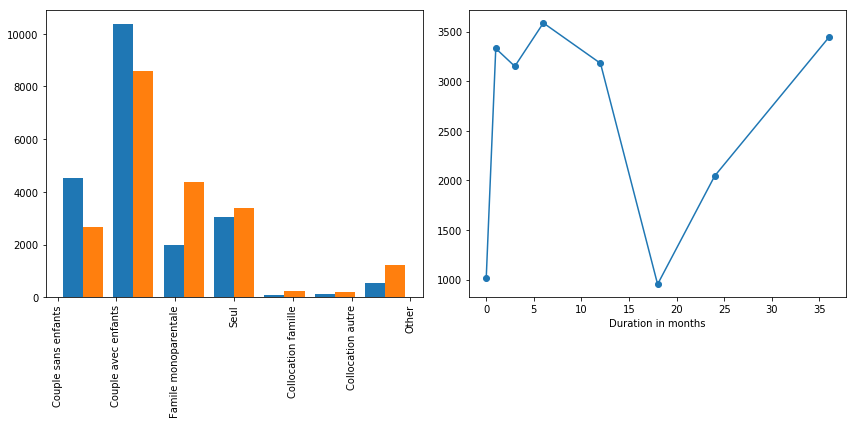

In [52]:
investigate_unemployed(df)